# Week 5 Assignment - General Adversarial Networks (GANs)
### Kaggle: I’m Something of a Painter Myself

By: Austin Jenkins

Class: CSCA 5642 - Introduction to Deep Learning

Github Repository: https://github.com/ajenkins198621/csca-5642-module5-gan-painter

Kaggle Competition: https://www.kaggle.com/competitions/gan-getting-started/overview

# I. Introduction

For this assignment, we are tasked to create a GAN model that can generate images of paintings. The dataset provided is a collection of paintings from Monet. The goal is to create a GAN model that can generate images of paintings that are similar to the paintings in the dataset.

## Load Libraries

In [1]:
import tensorflow as tf
import numpy as np
import re 
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import keras
from keras import *
from keras.layers import *
from keras import layers, Model, Sequential
from matplotlib import animation
import io
import os
import zipfile
import glob
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


### Try to use TPU to speed up the training process

Here we'll try to use TPU to speed up the training process.  I got inspiration for this from the following notebook: https://www.kaggle.com/code/dapy15/monet-using-gan.  Note, on my local computer I don't have the TPU runtime available, but for submitting the files to Kaggle, this should work.

In [2]:
print("TPU devices:", tf.config.experimental.list_logical_devices('TPU'))

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(strategy)


TPU devices: []


## Set default plot styles

I personally like the dark themed plots, so I'll set the default plot style to dark.

In [3]:
plt.style.use('dark_background')

## Load Data

Here I'll load the tfrec (Tensorflow Record) records.  We're using the tfrec images because they are more efficient to load and work with in Tensorflow.  Within the tfrec files, the images are stored as 256x256x3 images.  I got inspiration and instructions on how to load this data from the CycleGAN tutorial provided in the Kaggle competition: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

In [4]:
MONET_FILES = tf.io.gfile.glob(r'./kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
PHOTO_FILES = tf.io.gfile.glob(r'./kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

print('Monet TFRecord Files:', len(MONET_FILES))
print('Photo TFRecord Files:', len(PHOTO_FILES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Next, let's take a look at the samples within the tfrec files.

In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

monet_samples = count_data_items(MONET_FILES)
photo_samples = count_data_items(PHOTO_FILES)

print(f'Monet samples: {monet_samples}')
print(f'Photo samples: {photo_samples}')

Monet samples: 300
Photo samples: 7038


Here, we can see that there are 300 Monet samples and 7,038 photo samples.

We know the images are 128 x 128 so I'll store those in a constant for later use.  We also know it's an RGB image so we can store those channels in a constant as well.

In [6]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_SIZE = [IMAGE_WIDTH, IMAGE_HEIGHT]
CHANNELS = 3

Next we'll define a decode_image function which will take in an image and decode it into a 128x128x3 image.

In [7]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1, 1]
    return tf.reshape(image, [256, 256, 3])


Next, we'll define a read_tfrecord function which will take in a serialized example and parse it into an image and label.

In [8]:
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


We'll define a helper function to actually load the dataset.  This function will take in the filenames of the tfrec files and return a dataset.

In [9]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


Finally, we can load in the actual datasets.

In [10]:
monet_dataset = load_dataset(filenames=MONET_FILES, labeled=True).batch(1).prefetch(AUTOTUNE)
photo_dataset = load_dataset(filenames=PHOTO_FILES, labeled=True).batch(1).prefetch(AUTOTUNE)

# II. EDA

Now that the data is loaded in, we can take a look at some of the images to get a better understanding of what we're working with.  Here I'll plot a few of the images from the Monet dataset and the photo dataset.

In [11]:
def plot_images(dataset, title):
    num_images = 8
    img_size = (3, 3)

    rows = 2
    cols = num_images // rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(img_size[0] * cols, img_size[1] * rows))
    axes = axes.flatten()

    for i, val in enumerate(dataset.take(num_images)):
        axes[i].imshow((val[0] + 1) / 2)
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


2025-02-02 17:29:16.598734: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


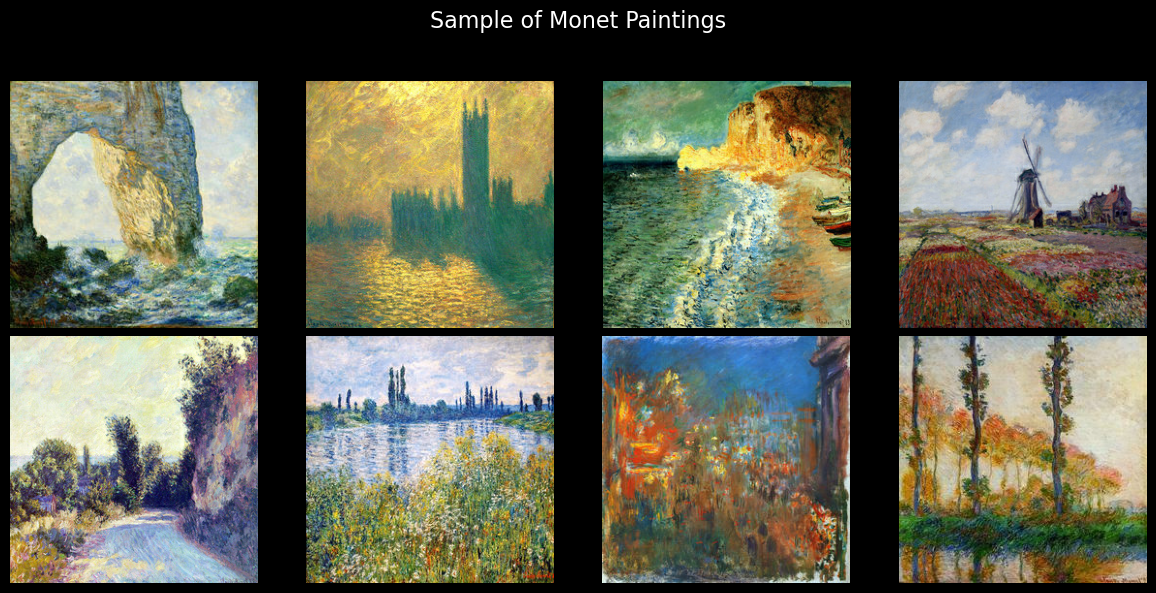

In [12]:
plot_images(monet_dataset, "Sample of Monet Paintings")

2025-02-02 17:29:16.934798: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


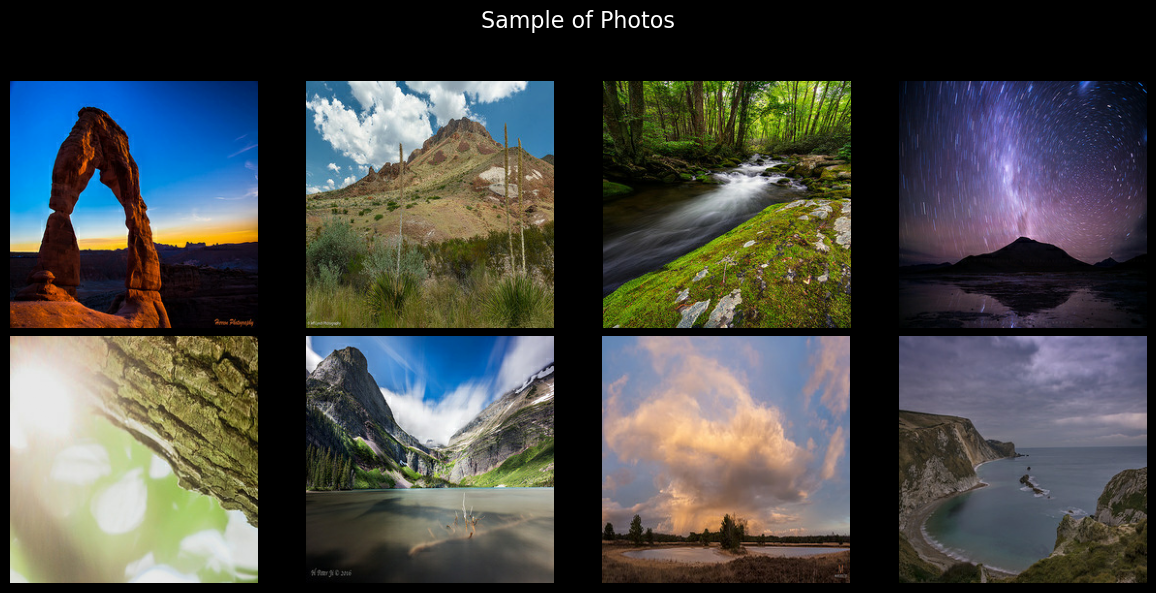

In [13]:
plot_images(photo_dataset, "Sample of Photos")

Ok, great!  The paintings and photos are loaded in and we can see that the paintings are of Monet's work and the photos are of various scenes.

# III. Model Architecture

## DCGAN - Version 1

I chose to use DCGAN for this assignment as we spent the most time learning about it in the course.  I'll go into more detail about the generator, discriminator, and loss functions in the next sections.

### Generator

The generator converts a random noise vector into a 256×256×3 RGB image.

- <strong>Input</strong>: A latent vector of size 128.
- <strong>Dense layer</strong>: Expands the noise vector to an 8×8×512 feature map.
- <strong>Batch Normalization</strong>: Applied after each layer to stabilize training and reduce collapse.
- <strong>Activation Functions</strong>: ReLU activation functions are used in all layers except the output, which uses a tanh activation.
- <strong>Conv2DTranspose Layers</strong>: Upscales the image from 8×8 → 16×16 → 32×32 → 64×64 → 128×128 → 256×256
- <strong>Final Layer</strong>:
    - A tanh activation scales the output to the range [-1,1].
    - The output is a 256×256×3 RGB image.
- <strong>Purpose</strong>: The generator learns to create realistic Monet-style images from random noise.

In [14]:
latent_dim = 128

generator = Sequential(
    [
        layers.Input(shape=(latent_dim,)),
        
        layers.Dense(8 * 8 * 512, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((8, 8, 512)),

        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")  # Now correctly reaches 256×256
    ],
    name="generator"
)

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 32)   │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 256, 256, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,114,115 (27.14 MB)

 Trainable params: 7,047,619 (26.88 MB)

 Non-trainable params: 66,496 (259.75 KB)

#### Discriminator

The discriminator classifies whether the images as real or fake.

- <strong>Input</strong>: A 256×256×3 image (either real or generated).
- <strong>Conv2D Layers</strong>: Downscales the image from 256×256 → 128×128 → 64×64 → 32×32 → 16×16 → 1×1.
- <strong>LeakyReLU Activations</strong>: LeakyReLU activation functions are used in all layers except the output.  This helps prevent dead neurons.
- <strong>Batch Normalization</strong>: Helps stabilize training by normalizing activations.
- <strong>Dropout</strong>: Started with a 0.2 value. Reduces overfitting by randomly dropping neurons during training.
- <strong>Final Layer</strong>: Sigmoid activation function outputs a probability (0 to 1) indicating whether the image is real or fake.
- <strong>Purpose</strong>: The discriminator distinguishes real Monet paintings from generated images.

In [15]:
discriminator = keras.Sequential(
    [
        layers.Input(shape=[IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS]),
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False),

        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ],
    name='discriminator'
    )
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 1)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 169)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 169)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,530 (10.56 MB)

 Trainable params: 2,765,738 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
def generate_latent_points(batch_size):
    return tf.random.normal(shape=(batch_size, latent_dim))

### Hyperparameters, Loss Function & Optimizers

- <strong>OPTIMIZER</strong>: Adam
- <strong>BETA</strong>: 0.5 - The momentum parameter for the Adam optimizer.
- <strong>LEARNING_RATE</strong> 0.0002 - How quickly weights are updated.  I started off with a fairly low value.
- <strong>EPOCHS</strong>: 500
- <strong>BATCH_SIZE</strong>: 32 - The # of images per training step.
- <strong>LOSS FUNCTION (generator)</strong>: Binary Crossentropy to produce images to fool the discriminator.
- <strong>LOSS FUNCTION (discriminator)</strong>: Binary Crossentropy to distinguish between real and fake images.


In [17]:
BETA = 0.5
LEARNING_RATE = 0.0002
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
EPOCHS = 500
BATCH_SIZE = 32

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Model Class

Ok, below is the GAN model class I'm using to accomplish several things, including the handling of the training, image generation and saving the results.

- <strong>train()</strong>:
    - Generates fake images from the random noise image.
    - Passes real & fake images through the discriminator to obtain classification scores.
    - Computes losses using the loss function.
    - Applies gradients to update the generator and discriminator.
- <strong>generate_images()</strong>: Generates fake images from the random noise image.
- <strong>save_images()</strong>: Saves a 5×5 grid of generated images for visualization.
- <strong>save_images_to_zip</strong>: Converts the images to JPG format and stores them in the filename provided.  Note, for the Kaggle competition the images needed to be in an images.zip file.  However, for the notebook I'm submitting to class I wanted to save both of the image zips.
- <strong>train_loop()</strong>: Trains the GAN model for the specified number of epochs.

In [26]:
import zipfile
import io
import time
import matplotlib.pyplot as plt
from PIL import Image

class GAN(Model):
    def __init__(self, noise_dim, seed, EPOCHS, BATCH_SIZE, generator, discriminator, dataset, num_model, total_images=photo_samples, save_interval=20, zip_name="images.zip"):
        self.noise_dim = noise_dim
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.generator = generator
        self.discriminator = discriminator
        self.dataset = dataset
        self.num = num_model
        self.seed = seed
        self.total_images = total_images 
        self.save_interval = save_interval

        # Optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        # Create a zip file to store images
        self.zip_filename = zip_name
        self.zip_buffer = zipfile.ZipFile(self.zip_filename, "w", zipfile.ZIP_DEFLATED)

        # Tracking variables
        self.image_count = 0
        self.mean_ls = []
        self.e_ls = []

    @tf.function
    def train(self, images):
        """ Perform one training step """
        noise = tf.random.normal([images.shape[0], self.noise_dim])
    
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
    
            real_images = tf.squeeze(images, axis=1)
            fake_images = generated_images
    
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)
    
            gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
            disc_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output) + \
                        tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    
        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    
        return {"g_loss": gen_loss, "d_loss": disc_loss}

    def generate_images(self):
        """ Generate images from latent noise vector """
        return self.generator.predict(self.seed)

    def save_images(self, directory, epoch, images):
        """ Save batch of generated images as PNG """
        os.makedirs(directory, exist_ok=True)
        gen_imgs = 0.5 * images + 0.5

        fig = plt.figure(figsize=(5, 5))
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.imshow(gen_imgs[i])
            plt.axis('off')

        plt.savefig(os.path.join(directory, f'image_at_epoch_{epoch:04d}.png'))
        plt.close()

    def save_images_to_zip(self, generated_images):
        """ Save images directly to zip file """
        for i in range(generated_images.shape[0]):
            if self.image_count >= self.total_images:
                return  

            image_array = ((generated_images[i] + 1) * 127.5).numpy().astype(np.uint8)
            img = Image.fromarray(image_array)

            img_bytes = io.BytesIO()
            img.save(img_bytes, format="JPEG")  # Save as JPG
            self.zip_buffer.writestr(f"image_{self.image_count}.jpg", img_bytes.getvalue())

            self.image_count += 1

    def plot_images(self, images):
        """ Display generated images """
        gen_imgs = 0.5 * images + 0.5

        fig = plt.figure(figsize=(10, 10))
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.imshow(gen_imgs[i])
            plt.axis('off')
        plt.show()

    def train_loop(self):
        """ Custom training loop with progress tracking and loss plotting """
        for epoch in range(self.EPOCHS):
            start_time = time.time()
            total_loss = 0.0
            num_batches = 0

            for image_batch in self.dataset:
                per_replica_losses = strategy.run(self.train, args=(image_batch,))
                loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
                total_loss += tf.reduce_mean(loss["g_loss"] + loss["d_loss"])
                num_batches += 1

                if (epoch + 1) % self.save_interval == 0 and self.image_count < self.total_images:
                    latent_vectors = tf.random.normal([self.BATCH_SIZE, self.noise_dim])
                    generated_images = self.generator(latent_vectors, training=False)
                    self.save_images_to_zip(generated_images)

            if num_batches > 0:
                mean_loss = total_loss / num_batches
            else:
                mean_loss = 0
            
            self.mean_ls.append(mean_loss.numpy() if hasattr(mean_loss, "numpy") else mean_loss)
            self.e_ls.append(epoch + 1)

            # print(f"Epoch {epoch + 1}/{self.EPOCHS} - Time: {time.time() - start_time:.2f}s - Mean Loss: {mean_loss:.4f} - Images Saved: {self.image_count}/{self.total_images}")

            if self.image_count >= self.total_images:
                print(f"Reached {self.total_images} images. Stopping early.")
                break

        # Close zip file after training
        self.zip_buffer.close()
        print(f"All images saved in {self.zip_filename}.")

        # Plot loss after training
        self.plot_loss_training()

    def plot_loss_training(self):
        """ Plot the training loss over epochs """
        plt.figure(figsize=(8, 6))
        plt.plot(self.e_ls, self.mean_ls, label='Average Loss per Epoch', linestyle='--', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('GAN Training Loss')
        plt.grid()
        plt.legend()
        plt.show()


### Training

2025-02-02 17:30:07.777124: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-02 17:31:46.440526: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-02 17:34:43.597268: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-02 17:40:51.849965: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-02 17:53:05.978177: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-02 18:15:52.353046: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-02 19:03:05.868086: I tensorflow/core/framework/local_rendezvous.cc:404] L

Reached 7038 images. Stopping early.
All images saved in images.zip.


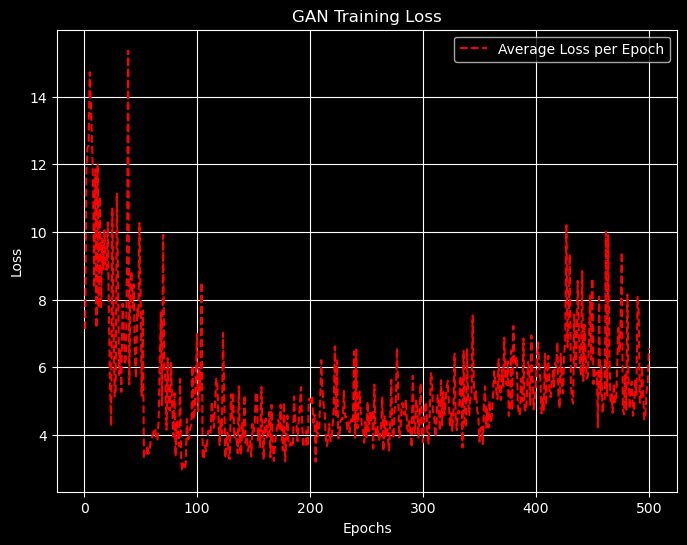

In [19]:
SAVE_INTERVAL = 20

with strategy.scope():
    BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
    monet_dataset = monet_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)

    gan = GAN(
        noise_dim=128, 
        seed=tf.random.normal([25, 128]), 
        EPOCHS=EPOCHS, 
        BATCH_SIZE=BATCH_SIZE, 
        generator=generator, 
        discriminator=discriminator, 
        dataset=monet_dataset, 
        num_model="1",
        save_interval=SAVE_INTERVAL
    )
    
    gan.train_loop()


Ok, as we see the loss is pretty high and volatile in the first ~100 or so epochs.  It then stabilizes in epocs from ~300-400.  However, the lost starts to increase in epochs greater than 400.  THis could indicate that there is some overfitting on the discriminator.

Ok great.  Now let's take a look at the images themselves.

In [29]:
def plot_latest_images_from_zip(zip_filename, title, num_images=8):
    with zipfile.ZipFile(zip_filename, 'r') as zip_file:
        image_filenames = sorted(
            [f for f in zip_file.namelist() if f.endswith('.jpg') or f.endswith('.png')],
            key=lambda x: int(x.split('_')[-1].split('.')[0])
        )
        latest_images = image_filenames[-num_images:] if len(image_filenames) >= num_images else image_filenames
        rows, cols = 2, num_images // 2
        fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        axes = axes.flatten()
        for i, filename in enumerate(latest_images):
            with zip_file.open(filename) as img_file:
                image = Image.open(img_file)
                image = np.array(image) / 255.0
            axes[i].imshow(image)
            axes[i].axis('off')

        plt.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



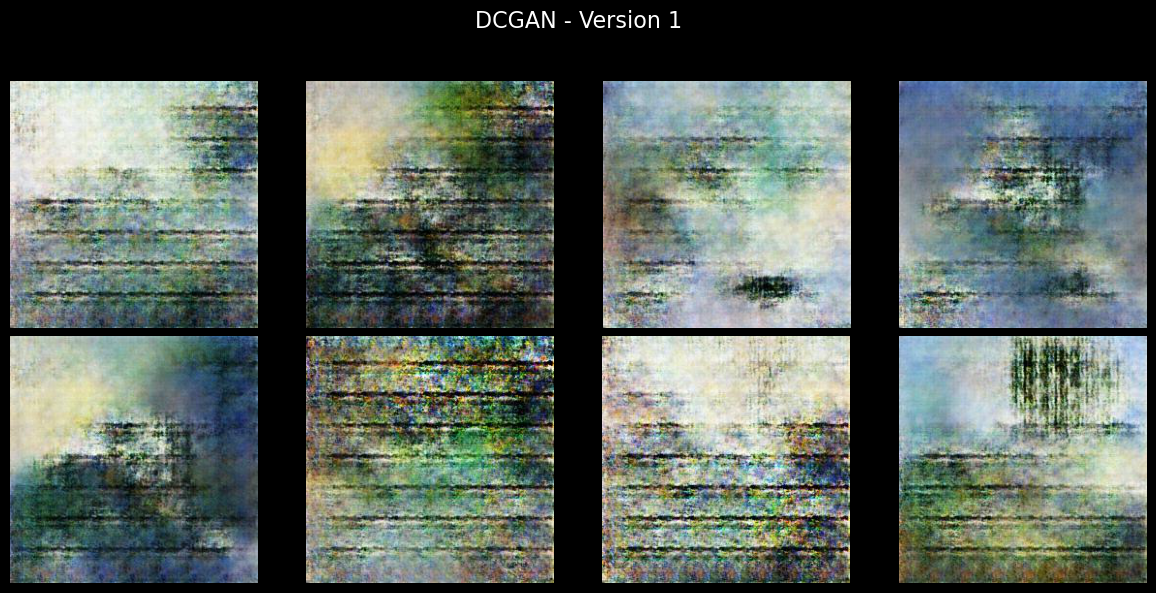

In [30]:
plot_latest_images_from_zip("images.zip", title="DCGAN - Version 1")

As we can see, the images are starting to take shape, but they're still very grainy and hard to make out.

Ok, cool.  Let's see how this model performed on the leaderboard.

In [31]:
def display_screenshot(file):
    if os.path.isfile(file):
        image = mpimg.imread(file)

        plt.figure(figsize=(16, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

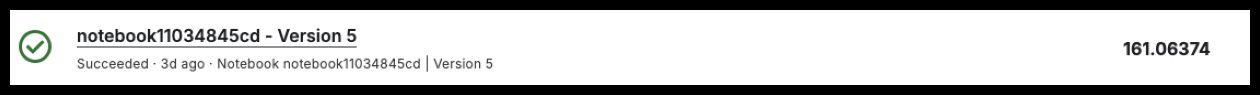

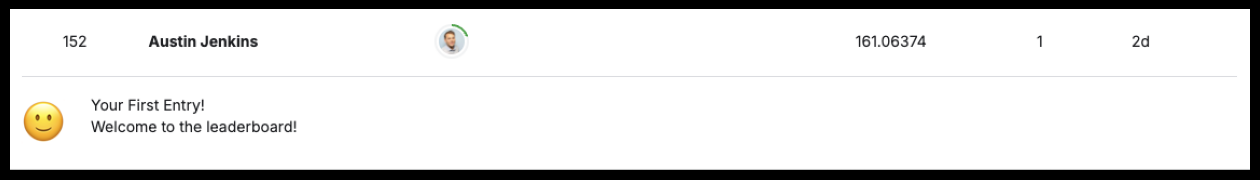

In [32]:
display_screenshot("results/model_1_submission.png")
display_screenshot("results/model_1_leaderboard.png")

Here we can see that the MFiDF performed pretty poorly as we're want to get a number closer to 0.  However, I was able to rank in the leaderboard at position 152.

## DCGAN (Version 2)

For the version 2, I want to tweak some of the hyperparameters and see if I can get better results.  Here I'm decreasing the learing rate to 0.0001, increasing the batch size from 32 to 64 and using different loss functions for the discriminator and generator.

In [22]:
BETA = 0.5
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EPOCHS = 500

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA)

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)


In [23]:
from keras.initializers import RandomNormal

generator = Sequential(
    [
        layers.Input(shape=(latent_dim,)),

        layers.Dense(8 * 8 * 512, use_bias=False, kernel_initializer=RandomNormal(stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),  # ✅ Use LeakyReLU instead of ReLU
        layers.Reshape((8, 8, 512)),

        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=RandomNormal(stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),  # ✅ ReLU → LeakyReLU

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=RandomNormal(stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),  

        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=RandomNormal(stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", use_bias=False, kernel_initializer=RandomNormal(stddev=0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh", kernel_initializer=RandomNormal(stddev=0.02))
    ],
    name="generator"
)

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 32)   │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,114,115 (27.14 MB)

 Trainable params: 7,047,619 (26.88 MB)

 Non-trainable params: 66,496 (259.75 KB)

In [24]:
discriminator = Sequential(
    [
        layers.Input(shape=[IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS]),

        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', use_bias=False,
                      kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                      kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=-0.01, max_value=0.01, rate=1.0)),  
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False,
                      kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                      kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=-0.01, max_value=0.01, rate=1.0)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False,
                      kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                      kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=-0.01, max_value=0.01, rate=1.0)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False,
                      kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                      kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=-0.01, max_value=0.01, rate=1.0)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False),

        layers.Flatten(),
        layers.Dropout(0.1),  # ✅ Lower dropout for better training
        layers.Dense(1, activation='sigmoid')
    ],
    name='discriminator'
)

discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 1)      │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 169)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 169)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,530 (10.56 MB)

 Trainable params: 2,765,738 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

2025-02-03 04:12:44.315553: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Reached 7038 images. Stopping early.
All images saved in images_2.zip.


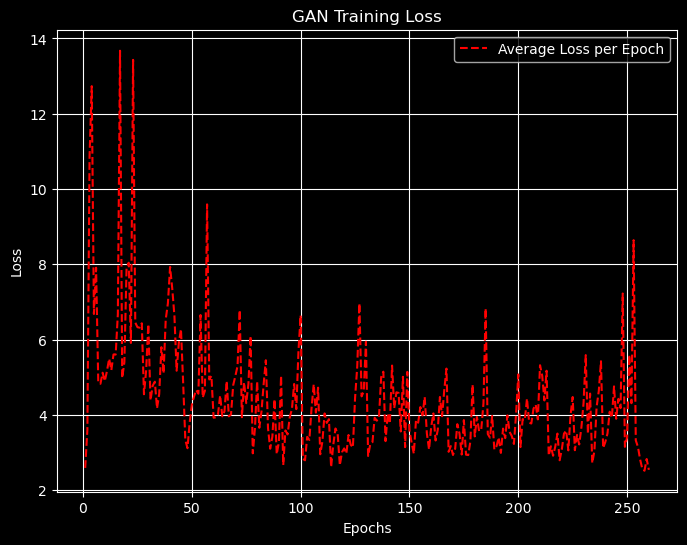

In [27]:
with strategy.scope():
    gan = GAN(
        noise_dim=latent_dim, 
        seed=tf.random.normal([25, latent_dim]), 
        EPOCHS=EPOCHS,  
        BATCH_SIZE=BATCH_SIZE,  
        generator=generator,
        discriminator=discriminator,
        dataset=monet_dataset,  
        num_model="1",
        save_interval=20,
        zip_name="images_2.zip"
    )

gan.gen_optimizer = generator_optimizer
gan.disc_optimizer = discriminator_optimizer
gan.generator_loss = generator_loss
gan.discriminator_loss = discriminator_loss

gan.train_loop()


As we can see, we the loss function jumps again above 250.  It also stopped much earlier than the first model.  This could be due to the lower learning rate.  

Now, let's take a look at the actual images.

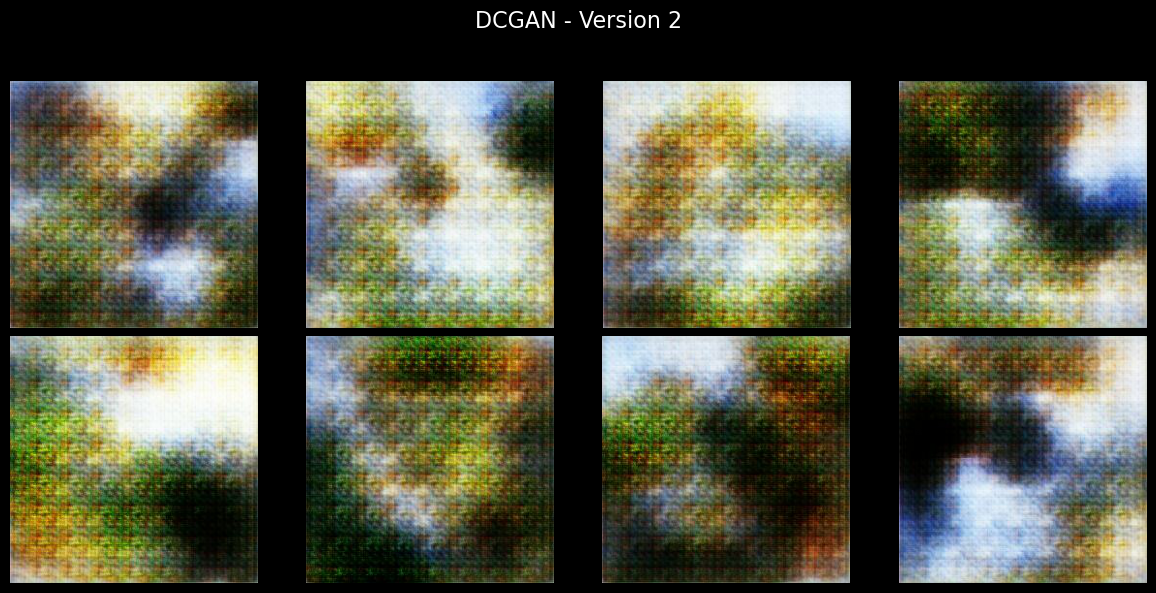

In [33]:
plot_latest_images_from_zip("images_2.zip", title="DCGAN - Version 2")

Once again teh images are pretty grainy and hard to make out.

Alright, now let's see how the second model performed in the Kaggle competition.

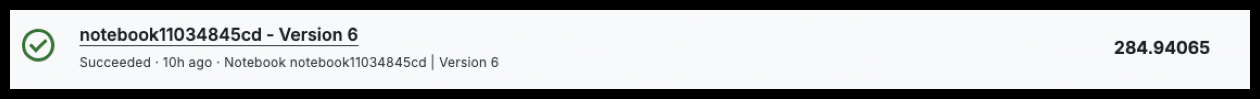

In [34]:
display_screenshot("results/model_2_submission.png")

# IV. Results and Analysis

In [ ]:
version_1_score = 161.1
version_2_score = 284.9

plt.figure(figsize=(10, 5))
plt.bar([f"Version 1 ({version_1_score})", f"Version 2 ({version_2_score})"], [version_1_score, version_2_score], color=['#FF914D', '#FF3D00'])
plt.title("Kaggle MiFID Scores")
plt.xlabel("Model")
plt.ylabel("Score")
plt.grid(True, linewidth=0.5, color='gray', linestyle='--')
plt.show()

As we can see the first version actually performed better than the second.  This indicates that some of the hyperparameters added in the second version may have been too aggressive.  However, the first version still didn't perform very well.  This could be due to the fact that the model is too simple or I'm not using the best models for this competition..  The Monet paintings are very complex and the model may not be able to learn the features of the paintings with the current architecture.

# V. Conclusion

Overall, I'm not super impressed with the results provided by the DCGAN model created in this assignment.  If I had more time, I would continue tweaking the model to generate more impressive images and get a better score.  However, running the model takes a long time and individual tweaks can take hours to run.  I would also consider using a different model architecture to see if I could get better results.

### Summary
- The first version of the DCGAN model performed better than the second version.  As we saw the first had an MFiDF of ~161 and the second performed much worse at ~285.
- In these two models, it appears that the simpler architecture and initial hyperparameters performed better than the more complex architecture and hyperparameters.
- The loss curves indicate increased volatility.  This could be due to over-regularization.
- Overfitting, we saw that there was overfitting in higher epochs.
- Adding more advanced techniques in the 2nd version didn't appear to help the model at all.

### Future Considerations
- Use a different optimizer than Adam
- Additional hyperparameter tuning.  I could continue tweaking the learning rate, the BETA, batch size and number of epochs.
- Try different models than DCGAN.  I saw in the example they used CycleGAN, and I could try that as well.
- I could apply more learning rate decay to decrease overfitting in higher epochs.
- 

# VI. References

- https://medium.com/@juanc.olamendy/understanding-relu-leakyrelu-and-prelu-a-comprehensive-guide-20f2775d3d64 
- https://towardsdatascience.com/tfrecords-explained-24b8f2133282 
- https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
- https://www.kaggle.com/code/dapy15/monet-using-gan